# EPASS with SimMatch Base for Freesound Audio Tagging

This notebook implements the **EPASS (Ensemble Projectors Aided for Semi-supervised Learning)** algorithm, using **SimMatch** as the base semi-supervised framework, for audio classification on the Freesound dataset (2018).

**Core Concepts:**

1.  **SimMatch Base:** Leverages both pseudo-labeling (like FixMatch) and instance similarity matching (contrastive learning) using two strongly augmented views of unlabeled data.
2.  **EPASS Enhancement:** Instead of a single MLP projector head (mapping encoder features to embeddings for contrastive loss), EPASS uses *multiple* projector heads. The embeddings from these heads are ensembled (averaged) to produce a more robust and less biased representation.
3.  **Goal:** Train models with 20% and 80% labeled data, aiming for high accuracy, demonstrating overfitting/underfitting via plots, and saving the best overall model.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
import itertools
import math
import copy

## 1. Configuration

In [ ]:
import torch
import random
import numpy as np
from dataclasses import dataclass, field
from typing import List

@dataclass
class Config:
    """configuration settings for epass+simmatch training."""
    # --- audio & spectrogram params ---
    sr: int = 32000              # audio sample rate
    duration: int = 5            # audio duration (seconds)
    n_mels: int = 128            # number of mel bands
    n_fft: int = 1024            # fft size
    hop_length: int = 512        # hop length

    # --- training params ---
    batch_size: int = 32         # combined batch size (adjust per gpu memory)
    epochs: int = 50             # number of epochs
    lr: float = 3e-4             # learning rate
    num_classes: int = 41        # number of classes (freesound dataset)
    # determine device dynamically
    device: torch.device = field(default_factory=lambda: torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    seed: int = 42               # random seed for reproducibility
    num_workers: int = 2         # dataloader workers

    # --- semi-supervised params (simmatch + epass) ---
    # use default_factory for mutable types like lists
    labeled_percents: List[float] = field(default_factory=lambda: [0.2, 0.8])
    val_percent: float = 0.1     # percentage of original training data for validation
    mu: int = 7                  # ratio unlabeled/labeled samples per batch
    wu: float = 1.0              # unsupervised classification loss weight
    wc: float = 1.0              # contrastive loss weight (simmatch)
    threshold: float = 0.95      # confidence threshold (tau) for pseudo-labeling
    temperature: float = 0.1     # temperature t for contrastive loss
    embedding_dim: int = 128     # dimension of projected embeddings
    num_projectors: int = 3      # number of projectors for epass

    # --- specaugment params (for strong augmentation) ---
    freq_mask_param: int = 27
    time_mask_param: int = 70    # adjust based on spectrogram width expected

    # --- model saving ---
    model_save_path: str = "best_epass_simmatch_model.pth"

    # --- data paths (update if necessary) ---
    train_csv_path: str = "/kaggle/input/freesound-audio-tagging/train.csv"
    test_csv_path: str = "/kaggle/input/freesound-audio-tagging/test_post_competition.csv"
    audio_train_dir: str = "/kaggle/input/freesound-audio-tagging/audio_train"
    audio_test_dir: str = "/kaggle/input/freesound-audio-tagging/audio_test"


def set_seed(seed: int):
    """sets random seeds for python, numpy, and torch for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        # necessary for multi-gpu setups
        torch.cuda.manual_seed_all(seed)
    # ensure deterministic behavior in cudnn
    torch.backends.cudnn.deterministic = True
    # benchmark=false can sometimes hinder performance but increases reproducibility
    torch.backends.cudnn.benchmark = False


# --- instantiate config and set seed ---
config = Config()
set_seed(config.seed)

# --- print key info (preserved exactly) ---
print(f"Device: {config.device}")
print(f"Number of projectors (EPASS): {config.num_projectors}")

Device: cuda
Number of projectors (EPASS): 3


## 2. Audio Preprocessing & Augmentation

In [ ]:
import librosa
import numpy as np
from typing import Optional # only needed if config might be None

# ----------------------------
# 2.1 audio preprocessing function
# ----------------------------
def preprocess_audio(
    path: str,
    sr: int = config.sr, # using config object from outer scope
    duration: int = config.duration,
    n_mels: int = config.n_mels,
    n_fft: int = config.n_fft,
    hop_length: int = config.hop_length
) -> np.ndarray:
    """
    loads audio, pads/truncates, computes, and normalizes mel spectrogram.

    args:
        path: path to the audio file.
        sr: target sample rate.
        duration: target duration in seconds.
        n_mels: number of mel bands.
        n_fft: fft window size.
        hop_length: hop length for stft.

    returns:
        normalized mel spectrogram (np.ndarray) or zeros on error.
    """
    max_len = sr * duration # calculate target length in samples
    try:
        # load audio file
        y, loaded_sr = librosa.load(path, sr=sr)

        # pad or truncate to fixed length
        if len(y) < max_len:
            # pad short files with zeros at the end
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        elif len(y) > max_len:
            # truncate long files
            y = y[:max_len]

        # compute mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        # convert power spectrogram to db scale
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # normalize spectrogram to [0, 1] range (min-max scaling)
        mel_min = mel_db.min()
        mel_max = mel_db.max()

        if mel_max == mel_min: # handle silent clips to avoid division by zero
            # return np.zeros_like(mel_db, dtype=np.float32) # alternative
            return np.zeros((n_mels, int(max_len / hop_length) + 1), dtype=np.float32)


        mel_norm = (mel_db - mel_min) / (mel_max - mel_min)

        # ensure float32 type for consistency (e.g., for pytorch)
        return mel_norm.astype(np.float32) # shape: (n_mels, time_steps)

    except Exception as e:
        # original print statement (preserved exactly)
        print(f"Error processing {path}: {e}")
        # return a zero array of the expected shape on error
        # calculate expected time steps based on max_len and hop_length
        time_steps = int(max_len / hop_length) + 1
        return np.zeros((n_mels, time_steps), dtype=np.float32)

### 2.2 Augmentation Functions

- **Weak Augmentation:** Identity (no change).
- **Strong Augmentation:** SpecAugment (frequency and time masking).

In [ ]:
import torch
import torchaudio
import torchaudio.transforms
import numpy as np
from typing import Union

# ----------------------------
# 2.2 augmentation functions
# ----------------------------

def weak_augment(mel_spec: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
    """applies weak augmentation (identity + tensor conversion + channel dim)."""
    # ensure input is a tensor
    if not isinstance(mel_spec, torch.Tensor):
        mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
    # add channel dimension (needed for many cnn models) -> (1, n_mels, time)
    return mel_spec.unsqueeze(0)

# --- initialize specaugment (strong augmentation transform) ---
# handle potential api changes in different torchaudio versions
spec_augment = None
try:
    # attempt initialization using likely older positional arguments
    # original print statement (preserved exactly)
    print("Attempting SpecAugment with positional args: (n_freq_masks, freq_mask_param, n_time_masks, time_mask_param)")
    spec_augment = torchaudio.transforms.SpecAugment(
        1,                     # n_freq_masks
        config.freq_mask_param, # freq_masking_param
        1,                     # n_time_masks
        config.time_mask_param, # time_masking_param
        iid_masks=True         # this might still be a keyword arg
    )
    # original print statement (preserved exactly)
    print("Successfully initialized SpecAugment with positional args.")
except TypeError:
    try:
        # if positional fails, try the keyword arguments (likely newer versions)
        # original print statement (preserved exactly)
        print("Positional args failed. Attempting SpecAugment with keyword args.")
        spec_augment = torchaudio.transforms.SpecAugment(
            freq_masking_param=config.freq_mask_param,
            time_masking_param=config.time_mask_param,
            freq_mask_count=1, # newer name for n_freq_masks
            time_mask_count=1, # newer name for n_time_masks
            iid_masks=True
        )
        # original print statement (preserved exactly)
        print("Successfully initialized SpecAugment with keyword args.")
    except TypeError as e:
        # if both methods fail, fall back to identity (no augmentation)
        # original print statements (preserved exactly)
        print(f"Failed to initialize SpecAugment with both positional and keyword params. Error: {e}")
        print("Using Identity augmentation as a fallback for strong_augment.")
        spec_augment = torch.nn.Identity() # fallback

def strong_augment(mel_spec: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
    """applies strong augmentation (specaugment or identity fallback)."""
    # ensure input is a tensor
    if not isinstance(mel_spec, torch.Tensor):
        mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
    # add channel dimension before applying specaugment -> (1, n_mels, time)
    mel_tensor = mel_spec.unsqueeze(0)
    # apply the initialized spec_augment transform
    augmented_mel = spec_augment(mel_tensor)
    return augmented_mel

Attempting SpecAugment with positional args: (n_freq_masks, freq_mask_param, n_time_masks, time_mask_param)
Successfully initialized SpecAugment with positional args.


## 3. Dataset Classes

- Labeled dataset returns one weakly augmented view and the label.
- Unlabeled dataset returns one weakly augmented view and *two* differently strongly augmented views (for SimMatch contrastive loss).
- Test/Validation dataset returns one weakly augmented view (or none) and the label.

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path 
import pandas as pd 
from typing import Callable, Dict, Tuple, Union
import numpy as np 
import os 


# ----------------------------
# 3. dataset classes
# ----------------------------

# --- base class for common functionality ---
class FreesoundBaseDataset(Dataset):
    """base dataset class for freesound audio data."""
    def __init__(
        self,
        df: pd.DataFrame,
        audio_dir: Union[str, Path],
        label_map: Dict[str, int], # mapping from class name string to integer index
        transform: Callable[[str], np.ndarray] = preprocess_audio # expects path -> numpy array
    ):
        self.df = df
        self.audio_dir = Path(audio_dir) # store as pathlib object
        self.label_map = label_map
        self.transform = transform
        # assume dataframe index contains the filenames (e.g., '00044347.wav')
        self.fnames = df.index.tolist()
        # pre-calculate full paths (optional optimization, depends on dataset size)
        # self.file_paths = [self.audio_dir / fname for fname in self.fnames]

    def __len__(self) -> int:
        """returns the number of samples in the dataset."""
        return len(self.fnames)

    def _get_mel(self, idx: int) -> np.ndarray:
        """loads and preprocesses audio file at index idx."""
        fname = self.fnames[idx]
        # construct full path using pathlib
        file_path = self.audio_dir / fname
        # apply the preprocessing transformation (e.g., to mel spectrogram)
        # ensure transform function handles potential errors and returns numpy array
        mel = self.transform(str(file_path)) # transform might expect string path
        return mel

    def _get_label(self, idx: int) -> int:
        """retrieves the integer label for the sample at index idx."""
        fname = self.fnames[idx]
        # assumes the dataframe has a 'label' column with class names
        label_name = self.df.loc[fname, 'label']
        return self.label_map[label_name]

# --- dataset for labeled data ---
class FreesoundLabeledDataset(FreesoundBaseDataset):
    """dataset for labeled data, returns augmented mel spectrogram and its label."""
    def __init__(
        self,
        df: pd.DataFrame,
        audio_dir: Union[str, Path],
        label_map: Dict[str, int],
        transform: Callable[[str], np.ndarray] = preprocess_audio,
        # augmentation applied to the labeled sample (typically weak)
        augment: Callable[[Union[np.ndarray, torch.Tensor]], torch.Tensor] = weak_augment
    ):
        super().__init__(df, audio_dir, label_map, transform)
        self.augment = augment

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """returns one augmented view and the label."""
        mel = self._get_mel(idx) # get numpy mel spec
        # apply augmentation (e.g., weak), should return tensor (c, h, w)
        mel_tensor_aug = self.augment(mel)
        label = self._get_label(idx)
        # return augmented tensor and label tensor
        return mel_tensor_aug, torch.tensor(label, dtype=torch.long)

# --- dataset for unlabeled data ---
class FreesoundUnlabeledDataset(FreesoundBaseDataset):
    """dataset for unlabeled data, returns multiple augmented views."""
    def __init__(
        self,
        df: pd.DataFrame,
        audio_dir: Union[str, Path],
        label_map: Dict[str, int], # stored but not used by __getitem__
        transform: Callable[[str], np.ndarray] = preprocess_audio,
        weak_aug: Callable[[Union[np.ndarray, torch.Tensor]], torch.Tensor] = weak_augment,
        strong_aug: Callable[[Union[np.ndarray, torch.Tensor]], torch.Tensor] = strong_augment
    ):
        super().__init__(df, audio_dir, label_map, transform)
        self.weak_aug = weak_aug
        self.strong_aug = strong_aug

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """returns one weak and two strong augmented views."""
        mel = self._get_mel(idx) # get numpy mel spec
        # generate required views
        mel_tensor_weak = self.weak_aug(mel)    # needed for pseudo-labeling
        mel_tensor_strong1 = self.strong_aug(mel) # needed for consistency loss / contrastive
        mel_tensor_strong2 = self.strong_aug(mel) # needed for contrastive
        # return the three views, label is not used/returned for unlabeled data
        return mel_tensor_weak, mel_tensor_strong1, mel_tensor_strong2

# --- dataset for testing/validation ---
class FreesoundEvalDataset(FreesoundBaseDataset):
    """dataset for evaluation, returns augmented mel spectrogram and its label."""
    def __init__(
        self,
        df: pd.DataFrame,
        audio_dir: Union[str, Path],
        label_map: Dict[str, int],
        transform: Callable[[str], np.ndarray] = preprocess_audio,
        # augmentation for evaluation (typically weak or none)
        augment: Callable[[Union[np.ndarray, torch.Tensor]], torch.Tensor] = weak_augment
    ):
        super().__init__(df, audio_dir, label_map, transform)
        self.augment = augment

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """returns one augmented view (usually weak/identity) and the label."""
        mel = self._get_mel(idx) # get numpy mel spec
        # apply augmentation (e.g., weak/identity), should return tensor (c, h, w)
        mel_tensor = self.augment(mel)
        label = self._get_label(idx)
        # return tensor and label tensor
        return mel_tensor, torch.tensor(label, dtype=torch.long)

### 4. Prepare Metadata, Label Map, and Data Splits

- Load `train.csv` and `test_post_competition.csv`.
- Create the label map.
- Split the original `train.csv` data into training and validation sets.
- Within the training loop, further split the training set into labeled and unlabeled based on the current `labeled_percent`.

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path # can be used with config paths
import numpy as np # imported for potential use, though not directly here
from typing import Optional, Dict, List # for type hints

# assume 'config' object exists with path attributes, seed, val_percent etc.

# -------------------------------------
# 4. prepare metadata and label map
# -------------------------------------
# load training csv
try:
    # pd.read_csv works fine with string paths from config
    train_df_full: pd.DataFrame = pd.read_csv(config.train_csv_path)
    # ensure 'fname' column exists and set it as index
    if 'fname' in train_df_full.columns:
        # use inplace=true to modify dataframe directly
        train_df_full.set_index("fname", inplace=True)
    elif train_df_full.index.name == 'fname':
         # already indexed correctly
         pass
    else:
         # handle case where 'fname' is missing or not the index appropriately
         raise ValueError("expected 'fname' column or index not found in train csv.")

    # basic validation
    if 'label' not in train_df_full.columns:
         raise ValueError("'label' column not found in train csv.")
    if train_df_full['label'].isnull().any():
         print("warning: found missing values in training labels. dropping these rows.")
         train_df_full.dropna(subset=['label'], inplace=True)

except FileNotFoundError:
    print(f"error: training csv not found at {config.train_csv_path}. cannot proceed.")
    # depending on script structure, might raise SystemExit() here
    raise
except ValueError as e:
     print(f"error loading training data: {e}")
     raise


# load test csv (optional, for final evaluation)
test_df: Optional[pd.DataFrame] = None # initialize to none
try:
    test_df = pd.read_csv(config.test_csv_path)
    if 'fname' in test_df.columns:
        test_df.set_index("fname", inplace=True)
    elif test_df.index.name == 'fname':
         pass # already indexed
    else:
         raise ValueError("expected 'fname' column or index not found in test csv.")

    # check for labels in test set
    if 'label' not in test_df.columns or test_df['label'].isnull().any():
        # original print statement (preserved exactly)
        print("Warning: Test CSV does not contain labels or has missing labels. Using manually_verified column if available.")
        # note: the original heuristic logic based on 'manually_verified' or filename was simplified/commented out.
        # if strict label checking is needed, implement here. for now, assume labels are needed.
        # if 'manually_verified' in test_df.columns and test_df['manually_verified'].notnull().all():
            # print("test set seems labeled based on filename/verification. proceeding with evaluation.") # original print
            # pass # or implement logic to derive labels if needed
        # else:
            # original print statement (preserved exactly)
            print("Cannot evaluate on test set without ground truth labels.")
            test_df = None # disable test evaluation if labels are missing/unreliable
    else:
        # labels exist and seem complete, drop any potential na rows just in case
        test_df = test_df.dropna(subset=['label'])

except FileNotFoundError:
    # original print statement (preserved exactly)
    print(f"Warning: Test CSV not found at {config.test_csv_path}. Skipping test evaluation.")
    test_df = None
except ValueError as e:
     print(f"error loading test data: {e}. skipping test evaluation.")
     test_df = None


# create label mapping (from sorted unique labels in the *full* training set)
labels: List[str] = sorted(train_df_full['label'].unique())
label_map: Dict[str, int] = {label: idx for idx, label in enumerate(labels)}
idx_to_label: Dict[int, str] = {idx: label for label, idx in label_map.items()}

# update config dynamically based on actual data (important!)
config.num_classes = len(labels)
# original print statements (preserved exactly)
print(f"Number of classes: {config.num_classes}")
print(f"Labels: {labels}")


# --- split full train data into training and validation sets ---
# use stratifiedshufflesplit for a representative validation set
sss_val = StratifiedShuffleSplit(
    n_splits=1, # perform split only once
    test_size=config.val_percent, # fraction for validation set
    random_state=config.seed      # ensure reproducibility
)
# get indices for the split based on labels for stratification
# use .index and .label attributes of the dataframe
train_idx, val_idx = next(sss_val.split(train_df_full.index, train_df_full['label']))

# create the training and validation dataframes using the indices
train_df: pd.DataFrame = train_df_full.iloc[train_idx]
val_df: pd.DataFrame = train_df_full.iloc[val_idx]

# original print statements (preserved exactly)
print(f"\nFull training samples: {len(train_df_full)}")
print(f"Split into: Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
if test_df is not None:
    # original print statement (preserved exactly)
    print(f"Test samples: {len(test_df)}")

# note: train_df will be split further into labeled/unlabeled later

Cannot evaluate on test set without ground truth labels.
Number of classes: 41
Labels: ['Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Burping_or_eructation', 'Bus', 'Cello', 'Chime', 'Clarinet', 'Computer_keyboard', 'Cough', 'Cowbell', 'Double_bass', 'Drawer_open_or_close', 'Electric_piano', 'Fart', 'Finger_snapping', 'Fireworks', 'Flute', 'Glockenspiel', 'Gong', 'Gunshot_or_gunfire', 'Harmonica', 'Hi-hat', 'Keys_jangling', 'Knock', 'Laughter', 'Meow', 'Microwave_oven', 'Oboe', 'Saxophone', 'Scissors', 'Shatter', 'Snare_drum', 'Squeak', 'Tambourine', 'Tearing', 'Telephone', 'Trumpet', 'Violin_or_fiddle', 'Writing']

Full training samples: 9473
Split into: Training samples: 8525, Validation samples: 948


### 5. Define the Model Architecture (Encoder + Classifier + EPASS Projectors)

- Use a pre-trained ResNet18 as the backbone encoder.
- Modify the first convolutional layer for 1-channel (spectrogram) input.
- Add a single linear classifier head.
- Add **multiple** MLP projector heads (EPASS).

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from typing import Tuple # for type hints

# ------------------------------------------------------------------
# 5. define the model architecture (encoder + classifier + projectors)
# ------------------------------------------------------------------
class EpassSimMatchNet(nn.Module):
    """
    network combining a resnet encoder, classifier head, and epass projectors.
    modified for single-channel (spectrogram) input.
    """
    def __init__(
        self,
        num_classes: int,
        embedding_dim: int,
        num_projectors: int,
        pretrained: bool = True
    ):
        super().__init__() # modern super() call
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.num_projectors = num_projectors

        # --- encoder (resnet18 base) ---
        # load pretrained resnet18
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        base_model = models.resnet18(weights=weights)

        # modify first conv layer for 1-channel input (spectrograms)
        # original: conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        base_model.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        # use all layers except the final fc layer as the encoder
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        # get output dimension from the original fc layer's input features
        encoder_output_dim: int = base_model.fc.in_features # 512 for resnet18

        # --- classifier head ---
        self.fc = nn.Linear(encoder_output_dim, self.num_classes)

        # --- epass projector heads ---
        # multiple mlp projectors applied to the encoder output
        self.projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(encoder_output_dim, encoder_output_dim), # optional intermediate layer
                nn.ReLU(), # consider batchnorm here too if needed
                nn.Linear(encoder_output_dim, self.embedding_dim) # final projection layer
            ) for _ in range(self.num_projectors)
        ])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        forward pass: computes features, logits, and ensembled projection.

        args:
            x: input tensor (batch, 1, height, width)

        returns:
            tuple containing:
                - logits (torch.tensor): classification output (batch, num_classes)
                - ensembled_embedding (torch.tensor): averaged projection (batch, embedding_dim)
        """
        # get features from encoder -> (batch, encoder_output_dim, 1, 1) for resnet
        features = self.encoder(x)
        # flatten features -> (batch, encoder_output_dim)
        flat_features = torch.flatten(features, 1)

        # --- classification output ---
        logits = self.fc(flat_features)

        # --- projections ---
        # get embeddings from all individual projectors
        embeddings: list[torch.Tensor] = [proj(flat_features) for proj in self.projectors]

        # ensemble (average) embeddings across projectors for contrastive loss
        # stack along dim 0 -> (num_projectors, batch, embedding_dim)
        # mean along dim 0 -> (batch, embedding_dim)
        ensembled_embedding = torch.mean(torch.stack(embeddings, dim=0), dim=0)

        # return logits and the single ensembled embedding
        return logits, ensembled_embedding

# --- instantiate the model ---
model = EpassSimMatchNet(
    num_classes=config.num_classes,
    embedding_dim=config.embedding_dim,
    num_projectors=config.num_projectors,
    # pretrained=true is default, can be set explicitly from config if needed
).to(config.device)

# --- print model info (preserved exactly) ---
# original print statement
print(f"Model created with {config.num_projectors} projectors and moved to device.")
# optional: print model summary
# print(model)
# calculate and print total trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# original print statement (with comma formatting)
print(f"Total trainable parameters: {num_params:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


Model created with 3 projectors and moved to device.
Total trainable parameters: 12,176,233


### 6. Create DataLoaders

- Create DataLoaders for labeled, unlabeled (dynamically sized), validation, and test sets.

In [ ]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from typing import Tuple, Optional, Dict # for type hints

# ----------------------------
# 6. create dataloaders (helper function)
# ----------------------------
def create_dataloaders(
    labeled_df: pd.DataFrame,
    unlabeled_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: Optional[pd.DataFrame],
    label_map: Dict[str, int], # pass label_map explicitly
    config: Any # use 'Any' or the specific Config class type if defined
) -> Tuple[DataLoader, DataLoader, DataLoader, Optional[DataLoader]]:
    """instantiates datasets and creates dataloaders."""

    # --- instantiate datasets ---
    # assumes augmentation functions are passed via defaults in dataset class definitions
    train_labeled_dataset = FreesoundLabeledDataset(
        labeled_df, config.audio_train_dir, label_map
    )
    train_unlabeled_dataset = FreesoundUnlabeledDataset(
        unlabeled_df, config.audio_train_dir, label_map
    )
    val_dataset = FreesoundEvalDataset(
        val_df, config.audio_train_dir, label_map
    )
    test_dataset = None
    if test_df is not None:
        test_dataset = FreesoundEvalDataset(
            test_df, config.audio_test_dir, label_map # use test audio dir
        )

    # --- calculate batch sizes ---
    # ensure labeled batch size >= 1, split total batch size according to mu
    labeled_bs = max(1, config.batch_size // (config.mu + 1))
    unlabeled_bs = config.batch_size - labeled_bs
    # original print statement (preserved exactly) - note the leading spaces
    print(f"  Using Labeled BS: {labeled_bs}, Unlabeled BS: {unlabeled_bs}")

    # --- define common dataloader arguments ---
    # pin_memory=true speeds up cpu-to-gpu transfer if enough memory
    common_loader_args = {
        "num_workers": config.num_workers,
        "pin_memory": True,
        "persistent_workers": config.num_workers > 0 # keep workers alive btw epochs if using > 0
    }

    # --- create dataloaders ---
    labeled_loader = DataLoader(
        train_labeled_dataset,
        batch_size=labeled_bs,
        shuffle=True,
        drop_last=True, # important for consistent steps per epoch in training
        **common_loader_args
    )

    unlabeled_loader = DataLoader(
        train_unlabeled_dataset,
        batch_size=unlabeled_bs,
        shuffle=True,
        drop_last=True, # important for consistent steps per epoch in training
        **common_loader_args
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size, # use full batch size for evaluation
        shuffle=False, # no need to shuffle validation set
        drop_last=False, # evaluate on all validation samples
        **common_loader_args
    )

    test_loader = None
    if test_dataset is not None:
        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            drop_last=False, # evaluate on all test samples
            **common_loader_args
        )

    print(f"  Loaders created. Num labeled batches/epoch: {len(labeled_loader)}, Num unlabeled batches/epoch: {len(unlabeled_loader)}")

    return labeled_loader, unlabeled_loader, val_loader, test_loader

### 7. Define Training and Evaluation Functions

- **`train_one_epoch`**: 
  - Takes model, optimizer, labeled/unlabeled loaders, loss criteria.
  - Iterates through both loaders simultaneously.
  - Calculates supervised loss (`loss_s`) on labeled data.
  - Calculates unsupervised classification loss (`loss_u`) using pseudo-labels.
  - Calculates unsupervised contrastive loss (`loss_c`) using ensembled embeddings from two strong views (SimMatch + EPASS).
  - Combines losses and performs backpropagation.
- **`evaluate`**: 
  - Standard evaluation loop using the classification head.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # or import from tqdm if not in notebook
import itertools # needed for cycle
import numpy as np
from typing import Tuple, List, Optional, Callable, Any # for type hints

# ---------------------------------------
# 7. training and evaluation functions
# ---------------------------------------

def train_one_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    labeled_loader: DataLoader,
    unlabeled_loader: DataLoader,
    criterion_s: Callable, # supervised loss criterion
    criterion_u: Callable, # unsupervised loss criterion (reduction='none')
    criterion_c: Callable, # contrastive loss criterion (e.g., crossentropy)
    epoch: int,
    config: Any # config object containing hyperparameters
) -> Tuple[float, float, float, float, float]:
    """trains the model for one epoch using labeled and unlabeled data."""
    model.train() # set model to training mode
    running_loss_s: float = 0.0
    running_loss_u: float = 0.0
    running_loss_c: float = 0.0
    correct_labeled: int = 0
    total_labeled: int = 0
    mask_ratios: List[float] = [] # tracks the ratio of samples above threshold

    # determine epoch length based on the unlabeled loader (usually larger)
    num_batches: int = len(unlabeled_loader)
    # cycle the labeled loader to match the length of the unlabeled one
    labeled_iter = itertools.cycle(labeled_loader)

    # progress bar for the epoch
    train_iterator = tqdm(unlabeled_loader, total=num_batches, desc=f"Epoch {epoch+1}", unit="batch")

    for batch_idx, (inputs_u_w, inputs_u_s1, inputs_u_s2) in enumerate(train_iterator):
        # get labeled data for this step from the cycling iterator
        try:
            inputs_l, labels_l = next(labeled_iter)
        except StopIteration:
             # this case should ideally not happen if both loaders have drop_last=true
             # and unlabeled_loader is indeed longer or equal. kept for robustness.
             # original print statement (preserved exactly)
             print("Warning: Labeled loader exhausted unexpectedly.")
             continue # skip this step if labeled data isn't available

        # move all data tensors to the configured device
        inputs_l, labels_l = inputs_l.to(config.device), labels_l.to(config.device)
        inputs_u_w = inputs_u_w.to(config.device)
        inputs_u_s1 = inputs_u_s1.to(config.device)
        inputs_u_s2 = inputs_u_s2.to(config.device)

        labeled_bs: int = inputs_l.size(0)
        unlabeled_bs: int = inputs_u_w.size(0)

        # --- supervised loss (on labeled data) ---
        # model returns (logits, ensembled_embedding)
        logits_l, _ = model(inputs_l)
        loss_s = criterion_s(logits_l, labels_l)

        # --- unsupervised losses (on unlabeled data) ---
        # 1. pseudo-labeling loss (consistency regularization - fixmatch style)
        with torch.no_grad(): # teacher predictions don't need gradients
            logits_u_w, _ = model(inputs_u_w) # weak view for pseudo-labels
            probs_u_w = torch.softmax(logits_u_w, dim=1)
            max_probs, pseudo_labels_u = torch.max(probs_u_w, dim=1)
            # create mask based on confidence threshold
            mask = (max_probs >= config.threshold).float()
            mask_ratios.append(mask.mean().item()) # track mask usage

        # student predictions on strong view 1
        logits_u_s1, embeddings_s1 = model(inputs_u_s1)
        # calculate unsupervised loss element-wise
        loss_u_vec = criterion_u(logits_u_s1, pseudo_labels_u) # uses reduction='none'
        # apply mask and average over batch
        loss_u = (loss_u_vec * mask).mean()

        # 2. contrastive loss (instance similarity - simmatch style)
        # get embeddings for strong view 2
        _, embeddings_s2 = model(inputs_u_s2)

        # l2 normalize embeddings before dot product similarity
        embeddings_s1_norm = F.normalize(embeddings_s1, dim=1)
        embeddings_s2_norm = F.normalize(embeddings_s2, dim=1)

        # calculate similarity matrix between the two strong views (s1 vs s2)
        # shape: (unlabeled_bs, unlabeled_bs)
        sim_matrix = torch.mm(embeddings_s1_norm, embeddings_s2_norm.t()) / config.temperature

        # targets for contrastive loss (match sample i in s1 with sample i in s2)
        targets = torch.arange(unlabeled_bs, device=config.device)

        # symmetric cross-entropy loss (s1 -> s2 and s2 -> s1)
        loss_c_vec1 = criterion_c(sim_matrix, targets)
        loss_c_vec2 = criterion_c(sim_matrix.t(), targets)
        loss_c_unmasked = (loss_c_vec1 + loss_c_vec2) / 2.0

        # apply the same confidence mask to contrastive loss (simmatch feature)
        # use .sum() / mask.sum() for correct average if mask is sparse, or .mean() if applied before averaging
        # original code uses .mean() after masking, which averages over the whole batch size including masked samples (giving them 0 loss contribution)
        loss_c = (loss_c_unmasked * mask).mean() # averages over unlabeled_bs

        # --- combine losses ---
        total_loss = loss_s + config.wu * loss_u + config.wc * loss_c

        # --- backpropagation and optimization ---
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        # note: lr scheduler step might happen here or after the epoch depending on its type

        # --- statistics accumulation ---
        # multiply item loss by batch size for correct overall epoch average later
        running_loss_s += loss_s.item() * labeled_bs
        running_loss_u += loss_u.item() * unlabeled_bs # loss_u is already avg over batch
        running_loss_c += loss_c.item() * unlabeled_bs # loss_c is already avg over batch

        # track labeled accuracy
        with torch.no_grad():
            preds_l = logits_l.argmax(dim=1)
            correct_labeled += (preds_l == labels_l).sum().item()
            total_labeled += labeled_bs

        # update progress bar postfix
        train_iterator.set_postfix(
            Loss=f"{total_loss.item():.4f}",
            Ls=f"{loss_s.item():.4f}",
            Lu=f"{loss_u.item():.4f}",
            Lc=f"{loss_c.item():.4f}",
            Mask=f"{mask.mean().item():.2f}" # show current batch mask ratio
        )

    # --- calculate epoch averages ---
    # average losses over the number of samples processed
    avg_loss_s = running_loss_s / total_labeled if total_labeled > 0 else 0
    # for u and c, they were already batch averages, scale by number of batches or total samples
    # total unlabeled samples = num_batches * average batch size (approx if drop_last=false)
    # since drop_last=true, total = num_batches * unlabeled_loader.batch_size
    # total_unlabeled_processed = num_batches * unlabeled_loader.batch_size if unlabeled_loader.batch_size else 0 # safer
    # simpler: average the running sum over number of batches
    avg_loss_u = (running_loss_u / unlabeled_loader.batch_size) / num_batches if unlabeled_loader.batch_size else 0
    avg_loss_c = (running_loss_c / unlabeled_loader.batch_size) / num_batches if unlabeled_loader.batch_size else 0
    # Let's re-evaluate the averaging:
    # running_loss_* accumulates item() * batch_size
    # So avg_loss should be running_loss / total_samples
    total_unlabeled_samples = num_batches * unlabeled_loader.batch_size if unlabeled_loader.batch_size else 0
    avg_loss_u = running_loss_u / total_unlabeled_samples if total_unlabeled_samples > 0 else 0
    avg_loss_c = running_loss_c / total_unlabeled_samples if total_unlabeled_samples > 0 else 0


    acc_labeled = correct_labeled / total_labeled if total_labeled > 0 else 0
    avg_mask_ratio = np.mean(mask_ratios) if mask_ratios else 0

    return avg_loss_s, avg_loss_u, avg_loss_c, acc_labeled, avg_mask_ratio


def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: Callable, # typically supervised criterion (e.g., nn.crossentropyloss)
    device: torch.device
) -> Tuple[float, float, List[int], List[int]]:
    """evaluates the model performance on a given dataset."""
    model.eval() # set model to evaluation mode
    running_loss: float = 0.0
    correct: int = 0
    total: int = 0
    all_preds: List[int] = []
    all_labels: List[int] = []

    with torch.no_grad(): # disable gradient calculations
        eval_iterator = tqdm(loader, desc="Evaluating", leave=False, unit="batch")
        for inputs, labels in eval_iterator:
            inputs, labels = inputs.to(device), labels.to(device)

            # model returns (logits, embedding), only need logits for eval
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)

            # accumulate loss weighted by batch size
            running_loss += loss.item() * inputs.size(0)
            # get predictions
            preds = outputs.argmax(dim=1)
            # accumulate correct predictions and total samples
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            # store predictions and labels for potential later analysis (e.g., confusion matrix)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # update progress bar description (optional)
            eval_iterator.set_postfix(Loss=f"{loss.item():.4f}", Acc=f"{(preds == labels).float().mean().item():.3f}")


    # calculate epoch loss and accuracy
    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = correct / total if total > 0 else 0

    return epoch_loss, epoch_acc, all_preds, all_labels

### 8. Training Loop

- Initialize model, optimizer, loss functions.
- Loop through specified labeled data percentages (20%, 80%).
  - For each percentage:
    - Split the training data into labeled and unlabeled sets.
    - Create dataloaders.
    - Re-initialize model weights and optimizer for a fair comparison.
    - Loop through epochs:
      - Call `train_one_epoch`.
      - Call `evaluate` on the validation set.
      - Track history (losses, accuracies, mask ratio).
      - Check if current validation accuracy is the best *overall*.
      - If so, save the model's state dictionary and record the best accuracy and corresponding labeled percentage.

In [ ]:
criterion_s = nn.CrossEntropyLoss() # supervised loss
criterion_u = nn.CrossEntropyLoss(reduction='none') # unsupervised classification loss
criterion_c = nn.CrossEntropyLoss(reduction='none') # contrastive loss (per-sample, masked & averaged)

best_val_acc_overall = 0.0
best_model_state = None
best_labeled_percent = -1
history = {}

for labeled_percent in config.labeled_percents:
    print(f"\n----- Training with {labeled_percent*100:.0f}% Labeled Data -----")
    history[labeled_percent] = {'train_loss_s': [], 'train_loss_u': [], 'train_loss_c': [],
                                 'train_acc_l': [], 'val_loss': [], 'val_acc': [], 'mask_ratio': []}

    # create labeled/unlabeled split
    sss_label = StratifiedShuffleSplit(n_splits=1, train_size=labeled_percent, random_state=config.seed + int(labeled_percent*100))
    labeled_idx, unlabeled_idx = next(sss_label.split(train_df.index, train_df['label']))
    labeled_df_run = train_df.iloc[labeled_idx]
    unlabeled_df_run = train_df.iloc[unlabeled_idx]
    print(f"  Labeled samples for this run: {len(labeled_df_run)}")
    print(f"  Unlabeled samples for this run: {len(unlabeled_df_run)}")

    # create dataloaders
    labeled_loader, unlabeled_loader, val_loader, test_loader = create_dataloaders(
        labeled_df_run, unlabeled_df_run, val_df, test_df, config
    )

    # re-initialize model and optimizer
    print("  Re-initializing model and optimizer...")
    model = EpassSimMatchNet(
        num_classes=config.num_classes,
        embedding_dim=config.embedding_dim,
        num_projectors=config.num_projectors
    ).to(config.device)
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    # optional: learning rate scheduler
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

    best_val_acc_run = 0.0 # best validation accuracy for this run

    # epoch loop
    for epoch in range(config.epochs):
        tr_loss_s, tr_loss_u, tr_loss_c, tr_acc_l, mask_ratio = train_one_epoch(
            model, optimizer, labeled_loader, unlabeled_loader,
            criterion_s, criterion_u, criterion_c, epoch
        )
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion_s, config.device)

        # optional: step the scheduler
        # scheduler.step()

        # log history
        history[labeled_percent]['train_loss_s'].append(tr_loss_s)
        history[labeled_percent]['train_loss_u'].append(tr_loss_u)
        history[labeled_percent]['train_loss_c'].append(tr_loss_c)
        history[labeled_percent]['train_acc_l'].append(tr_acc_l)
        history[labeled_percent]['val_loss'].append(val_loss)
        history[labeled_percent]['val_acc'].append(val_acc)
        history[labeled_percent]['mask_ratio'].append(mask_ratio)

        print(f"  Epoch {epoch+1}/{config.epochs} -> "
              f"Loss S: {tr_loss_s:.4f}, Loss U: {tr_loss_u:.4f}, Loss C: {tr_loss_c:.4f}, Acc (L): {tr_acc_l:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | Mask Ratio: {mask_ratio:.3f}")

        # check if best model overall
        if val_acc > best_val_acc_overall:
            best_val_acc_overall = val_acc
            best_labeled_percent = labeled_percent
            best_model_state = copy.deepcopy(model.state_dict()) # deep copy state dict
            print(f"  *** New best validation accuracy overall: {best_val_acc_overall:.4f} (from {labeled_percent*100:.0f}% run). Saving model state... ***")
            # save immediately or store and save at the end
            # torch.save(best_model_state, config.model_save_path)

# end of training loop
print(f"\nFinished training across all label percentages.")
print(f"Best overall validation accuracy: {best_val_acc_overall:.4f} achieved with {best_labeled_percent*100:.0f}% labeled data.")

# save the overall best model state
if best_model_state is not None:
    print(f"Saving the best overall model state to {config.model_save_path}")
    torch.save(best_model_state, config.model_save_path)
else:
    print("No best model state was saved (perhaps validation accuracy never improved?).")

# load the best model for final evaluation
print(f"\nLoading best overall model for final evaluation...")
if best_model_state is not None:
    model = EpassSimMatchNet( # recreate model structure
        num_classes=config.num_classes,
        embedding_dim=config.embedding_dim,
        num_projectors=config.num_projectors
    ).to(config.device)
    model.load_state_dict(best_model_state)
    print("Best model loaded successfully.")
else:
    print("Could not load a best model state. Evaluation will use the model from the last epoch of the last run.")
    # 'model' variable still holds the last trained model

# ensure test_loader exists if test_df exists
if test_df is not None:
    # create test_loader if not created in the last loop
    _, _, _, test_loader = create_dataloaders(labeled_df_run, unlabeled_df_run, val_df, test_df, config)
else:
    test_loader = None


----- Training with 20% Labeled Data -----
  Labeled samples for this run: 1705
  Unlabeled samples for this run: 6820
  Using Labeled BS: 4, Unlabeled BS: 28
  Loaders created. Num labeled batches/epoch: 426, Num unlabeled batches/epoch: 243
  Re-initializing model and optimizer...


Epoch 1:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/50 -> Loss S: 3.3016, Loss U: 0.0018, Loss C: 0.0056, Acc (L): 0.1409 | Val Loss: 2.7096, Val Acc: 0.2468 | Mask Ratio: 0.004
  *** New best validation accuracy overall: 0.2468 (from 20% run). Saving model state... ***


Epoch 2:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 2/50 -> Loss S: 2.7928, Loss U: 0.0024, Loss C: 0.0128, Acc (L): 0.2469 | Val Loss: 2.5089, Val Acc: 0.3175 | Mask Ratio: 0.014
  *** New best validation accuracy overall: 0.3175 (from 20% run). Saving model state... ***


Epoch 3:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 3/50 -> Loss S: 2.4620, Loss U: 0.0078, Loss C: 0.0241, Acc (L): 0.3025 | Val Loss: 2.1524, Val Acc: 0.4156 | Mask Ratio: 0.034
  *** New best validation accuracy overall: 0.4156 (from 20% run). Saving model state... ***


Epoch 4:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 4/50 -> Loss S: 2.2248, Loss U: 0.0138, Loss C: 0.0324, Acc (L): 0.3796 | Val Loss: 1.8977, Val Acc: 0.4852 | Mask Ratio: 0.060
  *** New best validation accuracy overall: 0.4852 (from 20% run). Saving model state... ***


Epoch 5:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 5/50 -> Loss S: 1.9552, Loss U: 0.0229, Loss C: 0.0494, Acc (L): 0.4794 | Val Loss: 1.9525, Val Acc: 0.4652 | Mask Ratio: 0.100


Epoch 6:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 6/50 -> Loss S: 1.7273, Loss U: 0.0272, Loss C: 0.0485, Acc (L): 0.5072 | Val Loss: 1.8890, Val Acc: 0.5211 | Mask Ratio: 0.133
  *** New best validation accuracy overall: 0.5211 (from 20% run). Saving model state... ***


Epoch 7:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 7/50 -> Loss S: 1.6274, Loss U: 0.0371, Loss C: 0.0603, Acc (L): 0.5494 | Val Loss: 1.6829, Val Acc: 0.5464 | Mask Ratio: 0.166
  *** New best validation accuracy overall: 0.5464 (from 20% run). Saving model state... ***


Epoch 8:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 8/50 -> Loss S: 1.3461, Loss U: 0.0513, Loss C: 0.0715, Acc (L): 0.6307 | Val Loss: 1.8149, Val Acc: 0.5601 | Mask Ratio: 0.216
  *** New best validation accuracy overall: 0.5601 (from 20% run). Saving model state... ***


Epoch 9:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 9/50 -> Loss S: 1.2304, Loss U: 0.0537, Loss C: 0.0753, Acc (L): 0.6461 | Val Loss: 1.6356, Val Acc: 0.6086 | Mask Ratio: 0.257
  *** New best validation accuracy overall: 0.6086 (from 20% run). Saving model state... ***


Epoch 10:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 10/50 -> Loss S: 1.0820, Loss U: 0.0606, Loss C: 0.0793, Acc (L): 0.7068 | Val Loss: 1.6146, Val Acc: 0.6076 | Mask Ratio: 0.290


Epoch 11:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 11/50 -> Loss S: 0.8939, Loss U: 0.0654, Loss C: 0.0804, Acc (L): 0.7387 | Val Loss: 1.5404, Val Acc: 0.6340 | Mask Ratio: 0.322
  *** New best validation accuracy overall: 0.6340 (from 20% run). Saving model state... ***


Epoch 12:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 12/50 -> Loss S: 0.9186, Loss U: 0.0691, Loss C: 0.0786, Acc (L): 0.7418 | Val Loss: 1.4439, Val Acc: 0.6582 | Mask Ratio: 0.340
  *** New best validation accuracy overall: 0.6582 (from 20% run). Saving model state... ***


Epoch 13:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 13/50 -> Loss S: 0.7580, Loss U: 0.0748, Loss C: 0.0738, Acc (L): 0.7860 | Val Loss: 1.6890, Val Acc: 0.6213 | Mask Ratio: 0.372


Epoch 14:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 14/50 -> Loss S: 0.7434, Loss U: 0.0949, Loss C: 0.0839, Acc (L): 0.8014 | Val Loss: 1.5218, Val Acc: 0.6487 | Mask Ratio: 0.385


Epoch 15:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 15/50 -> Loss S: 0.5921, Loss U: 0.0739, Loss C: 0.0803, Acc (L): 0.8272 | Val Loss: 1.4673, Val Acc: 0.6793 | Mask Ratio: 0.418
  *** New best validation accuracy overall: 0.6793 (from 20% run). Saving model state... ***


Epoch 16:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 16/50 -> Loss S: 0.4453, Loss U: 0.0753, Loss C: 0.0705, Acc (L): 0.8971 | Val Loss: 1.7311, Val Acc: 0.6382 | Mask Ratio: 0.451


Epoch 17:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 17/50 -> Loss S: 0.3840, Loss U: 0.0810, Loss C: 0.0715, Acc (L): 0.9012 | Val Loss: 1.4569, Val Acc: 0.6930 | Mask Ratio: 0.470
  *** New best validation accuracy overall: 0.6930 (from 20% run). Saving model state... ***


Epoch 18:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 18/50 -> Loss S: 0.3742, Loss U: 0.0872, Loss C: 0.0768, Acc (L): 0.8971 | Val Loss: 1.5199, Val Acc: 0.6888 | Mask Ratio: 0.493


Epoch 19:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 19/50 -> Loss S: 0.4005, Loss U: 0.0891, Loss C: 0.0723, Acc (L): 0.8848 | Val Loss: 1.6353, Val Acc: 0.6730 | Mask Ratio: 0.485


Epoch 20:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 20/50 -> Loss S: 0.2428, Loss U: 0.0959, Loss C: 0.0712, Acc (L): 0.9434 | Val Loss: 1.6303, Val Acc: 0.6909 | Mask Ratio: 0.523


Epoch 21:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 21/50 -> Loss S: 0.2888, Loss U: 0.1024, Loss C: 0.0679, Acc (L): 0.9187 | Val Loss: 1.6230, Val Acc: 0.6909 | Mask Ratio: 0.522


Epoch 22:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 22/50 -> Loss S: 0.2915, Loss U: 0.1010, Loss C: 0.0686, Acc (L): 0.9259 | Val Loss: 1.7968, Val Acc: 0.6593 | Mask Ratio: 0.530


Epoch 23:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 23/50 -> Loss S: 0.2022, Loss U: 0.1048, Loss C: 0.0685, Acc (L): 0.9496 | Val Loss: 1.5412, Val Acc: 0.7078 | Mask Ratio: 0.555
  *** New best validation accuracy overall: 0.7078 (from 20% run). Saving model state... ***


Epoch 24:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 24/50 -> Loss S: 0.1784, Loss U: 0.1022, Loss C: 0.0621, Acc (L): 0.9568 | Val Loss: 1.7062, Val Acc: 0.6783 | Mask Ratio: 0.571


Epoch 25:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 25/50 -> Loss S: 0.2029, Loss U: 0.0899, Loss C: 0.0648, Acc (L): 0.9496 | Val Loss: 1.5106, Val Acc: 0.6878 | Mask Ratio: 0.558


Epoch 26:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 26/50 -> Loss S: 0.1777, Loss U: 0.1018, Loss C: 0.0635, Acc (L): 0.9506 | Val Loss: 1.7654, Val Acc: 0.7057 | Mask Ratio: 0.578


Epoch 27:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 27/50 -> Loss S: 0.2158, Loss U: 0.1074, Loss C: 0.0633, Acc (L): 0.9403 | Val Loss: 1.7159, Val Acc: 0.6909 | Mask Ratio: 0.582


Epoch 28:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 28/50 -> Loss S: 0.2682, Loss U: 0.1021, Loss C: 0.0605, Acc (L): 0.9290 | Val Loss: 1.7495, Val Acc: 0.6825 | Mask Ratio: 0.570


Epoch 29:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 29/50 -> Loss S: 0.2020, Loss U: 0.1080, Loss C: 0.0619, Acc (L): 0.9527 | Val Loss: 1.5628, Val Acc: 0.7173 | Mask Ratio: 0.573
  *** New best validation accuracy overall: 0.7173 (from 20% run). Saving model state... ***


Epoch 30:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 30/50 -> Loss S: 0.1434, Loss U: 0.1022, Loss C: 0.0554, Acc (L): 0.9630 | Val Loss: 1.6048, Val Acc: 0.7194 | Mask Ratio: 0.613
  *** New best validation accuracy overall: 0.7194 (from 20% run). Saving model state... ***


Epoch 31:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 31/50 -> Loss S: 0.1518, Loss U: 0.1083, Loss C: 0.0609, Acc (L): 0.9609 | Val Loss: 1.8573, Val Acc: 0.6951 | Mask Ratio: 0.610


Epoch 32:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 32/50 -> Loss S: 0.2225, Loss U: 0.1001, Loss C: 0.0522, Acc (L): 0.9393 | Val Loss: 1.6608, Val Acc: 0.6930 | Mask Ratio: 0.597


Epoch 33:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 33/50 -> Loss S: 0.1855, Loss U: 0.1027, Loss C: 0.0551, Acc (L): 0.9496 | Val Loss: 1.6547, Val Acc: 0.7099 | Mask Ratio: 0.615


Epoch 34:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 34/50 -> Loss S: 0.1460, Loss U: 0.1020, Loss C: 0.0544, Acc (L): 0.9630 | Val Loss: 1.6895, Val Acc: 0.6983 | Mask Ratio: 0.630


Epoch 35:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 35/50 -> Loss S: 0.1344, Loss U: 0.1036, Loss C: 0.0554, Acc (L): 0.9671 | Val Loss: 1.5956, Val Acc: 0.7268 | Mask Ratio: 0.630
  *** New best validation accuracy overall: 0.7268 (from 20% run). Saving model state... ***


Epoch 36:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 36/50 -> Loss S: 0.0779, Loss U: 0.1034, Loss C: 0.0537, Acc (L): 0.9825 | Val Loss: 1.8031, Val Acc: 0.7162 | Mask Ratio: 0.656


Epoch 37:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 37/50 -> Loss S: 0.1523, Loss U: 0.0924, Loss C: 0.0518, Acc (L): 0.9599 | Val Loss: 1.6710, Val Acc: 0.7025 | Mask Ratio: 0.646


Epoch 38:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 38/50 -> Loss S: 0.1493, Loss U: 0.0937, Loss C: 0.0480, Acc (L): 0.9609 | Val Loss: 1.9136, Val Acc: 0.6962 | Mask Ratio: 0.638


Epoch 39:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 39/50 -> Loss S: 0.1481, Loss U: 0.0941, Loss C: 0.0501, Acc (L): 0.9630 | Val Loss: 2.0995, Val Acc: 0.7015 | Mask Ratio: 0.637


Epoch 40:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 40/50 -> Loss S: 0.1588, Loss U: 0.0956, Loss C: 0.0506, Acc (L): 0.9568 | Val Loss: 1.7353, Val Acc: 0.6973 | Mask Ratio: 0.637


Epoch 41:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 41/50 -> Loss S: 0.1507, Loss U: 0.0980, Loss C: 0.0503, Acc (L): 0.9609 | Val Loss: 1.7330, Val Acc: 0.6983 | Mask Ratio: 0.638


Epoch 42:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 42/50 -> Loss S: 0.1212, Loss U: 0.0970, Loss C: 0.0477, Acc (L): 0.9712 | Val Loss: 1.5483, Val Acc: 0.7194 | Mask Ratio: 0.654


Epoch 43:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 43/50 -> Loss S: 0.1061, Loss U: 0.0889, Loss C: 0.0464, Acc (L): 0.9722 | Val Loss: 1.6614, Val Acc: 0.7205 | Mask Ratio: 0.669


Epoch 44:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 44/50 -> Loss S: 0.1006, Loss U: 0.0923, Loss C: 0.0449, Acc (L): 0.9743 | Val Loss: 1.8636, Val Acc: 0.6888 | Mask Ratio: 0.672


Epoch 45:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 45/50 -> Loss S: 0.1294, Loss U: 0.1065, Loss C: 0.0509, Acc (L): 0.9640 | Val Loss: 2.1251, Val Acc: 0.6783 | Mask Ratio: 0.657


Epoch 46:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 46/50 -> Loss S: 0.1139, Loss U: 0.1012, Loss C: 0.0479, Acc (L): 0.9671 | Val Loss: 1.7386, Val Acc: 0.7300 | Mask Ratio: 0.663
  *** New best validation accuracy overall: 0.7300 (from 20% run). Saving model state... ***


Epoch 47:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 47/50 -> Loss S: 0.0572, Loss U: 0.0966, Loss C: 0.0439, Acc (L): 0.9877 | Val Loss: 1.8127, Val Acc: 0.7257 | Mask Ratio: 0.687


Epoch 48:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 48/50 -> Loss S: 0.0344, Loss U: 0.0957, Loss C: 0.0437, Acc (L): 0.9928 | Val Loss: 1.9150, Val Acc: 0.7226 | Mask Ratio: 0.704


Epoch 49:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 49/50 -> Loss S: 0.1079, Loss U: 0.0970, Loss C: 0.0468, Acc (L): 0.9650 | Val Loss: 1.8107, Val Acc: 0.7120 | Mask Ratio: 0.686


Epoch 50:   0%|          | 0/243 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 50/50 -> Loss S: 0.0768, Loss U: 0.0928, Loss C: 0.0419, Acc (L): 0.9794 | Val Loss: 1.8517, Val Acc: 0.7046 | Mask Ratio: 0.691

----- Training with 80% Labeled Data -----
  Labeled samples for this run: 6820
  Unlabeled samples for this run: 1705
  Using Labeled BS: 4, Unlabeled BS: 28
  Loaders created. Num labeled batches/epoch: 1705, Num unlabeled batches/epoch: 60
  Re-initializing model and optimizer...


Epoch 1:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/50 -> Loss S: 3.5514, Loss U: 0.0003, Loss C: 0.0008, Acc (L): 0.1292 | Val Loss: 3.3299, Val Acc: 0.1624 | Mask Ratio: 0.001


Epoch 2:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 2/50 -> Loss S: 3.4259, Loss U: 0.0000, Loss C: 0.0000, Acc (L): 0.1375 | Val Loss: 3.3094, Val Acc: 0.1656 | Mask Ratio: 0.000


Epoch 3:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 3/50 -> Loss S: 3.2123, Loss U: 0.0000, Loss C: 0.0000, Acc (L): 0.1417 | Val Loss: 2.8752, Val Acc: 0.2416 | Mask Ratio: 0.000


Epoch 4:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 4/50 -> Loss S: 3.1306, Loss U: 0.0001, Loss C: 0.0057, Acc (L): 0.1542 | Val Loss: 2.9091, Val Acc: 0.2162 | Mask Ratio: 0.004


Epoch 5:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 5/50 -> Loss S: 2.9910, Loss U: 0.0007, Loss C: 0.0071, Acc (L): 0.1875 | Val Loss: 2.5016, Val Acc: 0.3027 | Mask Ratio: 0.004


Epoch 6:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 6/50 -> Loss S: 2.8303, Loss U: 0.0025, Loss C: 0.0076, Acc (L): 0.2250 | Val Loss: 2.5655, Val Acc: 0.2711 | Mask Ratio: 0.005


Epoch 7:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 7/50 -> Loss S: 2.8355, Loss U: 0.0024, Loss C: 0.0113, Acc (L): 0.1750 | Val Loss: 2.5198, Val Acc: 0.3091 | Mask Ratio: 0.012


Epoch 8:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 8/50 -> Loss S: 2.7254, Loss U: 0.0023, Loss C: 0.0136, Acc (L): 0.2417 | Val Loss: 2.7855, Val Acc: 0.3122 | Mask Ratio: 0.012


Epoch 9:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 9/50 -> Loss S: 2.7112, Loss U: 0.0046, Loss C: 0.0256, Acc (L): 0.2333 | Val Loss: 2.5271, Val Acc: 0.3249 | Mask Ratio: 0.034


Epoch 10:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 10/50 -> Loss S: 2.7209, Loss U: 0.0025, Loss C: 0.0160, Acc (L): 0.2167 | Val Loss: 2.3203, Val Acc: 0.3565 | Mask Ratio: 0.026


Epoch 11:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 11/50 -> Loss S: 2.6350, Loss U: 0.0056, Loss C: 0.0123, Acc (L): 0.2958 | Val Loss: 2.2756, Val Acc: 0.3513 | Mask Ratio: 0.018


Epoch 12:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 12/50 -> Loss S: 2.6385, Loss U: 0.0047, Loss C: 0.0095, Acc (L): 0.2917 | Val Loss: 2.2846, Val Acc: 0.3597 | Mask Ratio: 0.021


Epoch 13:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 13/50 -> Loss S: 2.3733, Loss U: 0.0069, Loss C: 0.0152, Acc (L): 0.3750 | Val Loss: 2.0274, Val Acc: 0.4103 | Mask Ratio: 0.027


Epoch 14:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 14/50 -> Loss S: 2.3869, Loss U: 0.0069, Loss C: 0.0185, Acc (L): 0.3333 | Val Loss: 2.1437, Val Acc: 0.3987 | Mask Ratio: 0.032


Epoch 15:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 15/50 -> Loss S: 2.3871, Loss U: 0.0105, Loss C: 0.0206, Acc (L): 0.2875 | Val Loss: 2.1298, Val Acc: 0.4304 | Mask Ratio: 0.024


Epoch 16:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 16/50 -> Loss S: 2.2784, Loss U: 0.0033, Loss C: 0.0195, Acc (L): 0.3875 | Val Loss: 2.2192, Val Acc: 0.4473 | Mask Ratio: 0.033


Epoch 17:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 17/50 -> Loss S: 2.2323, Loss U: 0.0059, Loss C: 0.0262, Acc (L): 0.3500 | Val Loss: 2.0136, Val Acc: 0.4525 | Mask Ratio: 0.045


Epoch 18:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 18/50 -> Loss S: 2.0563, Loss U: 0.0122, Loss C: 0.0318, Acc (L): 0.4917 | Val Loss: 2.0211, Val Acc: 0.4705 | Mask Ratio: 0.046


Epoch 19:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 19/50 -> Loss S: 2.2128, Loss U: 0.0168, Loss C: 0.0325, Acc (L): 0.4000 | Val Loss: 1.7792, Val Acc: 0.5137 | Mask Ratio: 0.052


Epoch 20:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 20/50 -> Loss S: 1.9642, Loss U: 0.0125, Loss C: 0.0332, Acc (L): 0.4417 | Val Loss: 2.1731, Val Acc: 0.4441 | Mask Ratio: 0.061


Epoch 21:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 21/50 -> Loss S: 2.1083, Loss U: 0.0356, Loss C: 0.0628, Acc (L): 0.4125 | Val Loss: 2.1433, Val Acc: 0.4494 | Mask Ratio: 0.082


Epoch 22:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 22/50 -> Loss S: 2.1497, Loss U: 0.0254, Loss C: 0.0513, Acc (L): 0.3917 | Val Loss: 1.9519, Val Acc: 0.4842 | Mask Ratio: 0.083


Epoch 23:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 23/50 -> Loss S: 2.2072, Loss U: 0.0193, Loss C: 0.0430, Acc (L): 0.3667 | Val Loss: 1.8269, Val Acc: 0.4863 | Mask Ratio: 0.065


Epoch 24:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 24/50 -> Loss S: 1.9806, Loss U: 0.0262, Loss C: 0.0405, Acc (L): 0.4417 | Val Loss: 1.7558, Val Acc: 0.5084 | Mask Ratio: 0.082


Epoch 25:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 25/50 -> Loss S: 1.9024, Loss U: 0.0305, Loss C: 0.0399, Acc (L): 0.5375 | Val Loss: 1.7735, Val Acc: 0.5380 | Mask Ratio: 0.095


Epoch 26:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 26/50 -> Loss S: 1.9919, Loss U: 0.0270, Loss C: 0.0538, Acc (L): 0.4375 | Val Loss: 1.7882, Val Acc: 0.5137 | Mask Ratio: 0.111


Epoch 27:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 27/50 -> Loss S: 1.9084, Loss U: 0.0267, Loss C: 0.0362, Acc (L): 0.4833 | Val Loss: 1.6977, Val Acc: 0.5475 | Mask Ratio: 0.104


Epoch 28:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 28/50 -> Loss S: 1.7305, Loss U: 0.0342, Loss C: 0.0530, Acc (L): 0.5208 | Val Loss: 1.6057, Val Acc: 0.5770 | Mask Ratio: 0.121


Epoch 29:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 29/50 -> Loss S: 2.0233, Loss U: 0.0199, Loss C: 0.0516, Acc (L): 0.4750 | Val Loss: 1.7901, Val Acc: 0.5580 | Mask Ratio: 0.135


Epoch 30:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 30/50 -> Loss S: 1.9776, Loss U: 0.0332, Loss C: 0.0424, Acc (L): 0.4917 | Val Loss: 1.9131, Val Acc: 0.4937 | Mask Ratio: 0.126


Epoch 31:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 31/50 -> Loss S: 1.9486, Loss U: 0.0359, Loss C: 0.0425, Acc (L): 0.4750 | Val Loss: 1.6758, Val Acc: 0.5517 | Mask Ratio: 0.123


Epoch 32:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 32/50 -> Loss S: 1.7857, Loss U: 0.0455, Loss C: 0.0617, Acc (L): 0.5208 | Val Loss: 1.8522, Val Acc: 0.5274 | Mask Ratio: 0.143


Epoch 33:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 33/50 -> Loss S: 1.7932, Loss U: 0.0389, Loss C: 0.0668, Acc (L): 0.5208 | Val Loss: 1.7019, Val Acc: 0.5506 | Mask Ratio: 0.154


Epoch 34:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 34/50 -> Loss S: 1.6356, Loss U: 0.0483, Loss C: 0.0499, Acc (L): 0.5833 | Val Loss: 1.4810, Val Acc: 0.5981 | Mask Ratio: 0.170


Epoch 35:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 35/50 -> Loss S: 1.7415, Loss U: 0.0376, Loss C: 0.0492, Acc (L): 0.5125 | Val Loss: 1.5659, Val Acc: 0.5854 | Mask Ratio: 0.164


Epoch 36:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 36/50 -> Loss S: 1.7233, Loss U: 0.0406, Loss C: 0.0442, Acc (L): 0.5500 | Val Loss: 2.0266, Val Acc: 0.5306 | Mask Ratio: 0.168


Epoch 37:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 37/50 -> Loss S: 1.6260, Loss U: 0.0348, Loss C: 0.0577, Acc (L): 0.5833 | Val Loss: 1.5001, Val Acc: 0.5865 | Mask Ratio: 0.174


Epoch 38:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 38/50 -> Loss S: 1.7170, Loss U: 0.0428, Loss C: 0.0546, Acc (L): 0.5292 | Val Loss: 1.5520, Val Acc: 0.5918 | Mask Ratio: 0.171


Epoch 39:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 39/50 -> Loss S: 1.7350, Loss U: 0.0445, Loss C: 0.0688, Acc (L): 0.5292 | Val Loss: 1.4701, Val Acc: 0.6076 | Mask Ratio: 0.218


Epoch 40:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 40/50 -> Loss S: 1.5503, Loss U: 0.0503, Loss C: 0.0644, Acc (L): 0.5500 | Val Loss: 1.5472, Val Acc: 0.6086 | Mask Ratio: 0.221


Epoch 41:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 41/50 -> Loss S: 1.6602, Loss U: 0.0468, Loss C: 0.0543, Acc (L): 0.5583 | Val Loss: 1.6240, Val Acc: 0.5897 | Mask Ratio: 0.208


Epoch 42:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 42/50 -> Loss S: 1.7981, Loss U: 0.0474, Loss C: 0.0508, Acc (L): 0.5417 | Val Loss: 1.4380, Val Acc: 0.6234 | Mask Ratio: 0.206


Epoch 43:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 43/50 -> Loss S: 1.5130, Loss U: 0.0493, Loss C: 0.0593, Acc (L): 0.5625 | Val Loss: 1.5522, Val Acc: 0.5992 | Mask Ratio: 0.234


Epoch 44:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 44/50 -> Loss S: 1.5703, Loss U: 0.0558, Loss C: 0.0607, Acc (L): 0.5583 | Val Loss: 1.3431, Val Acc: 0.6308 | Mask Ratio: 0.233


Epoch 45:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 45/50 -> Loss S: 1.3231, Loss U: 0.0593, Loss C: 0.0694, Acc (L): 0.6333 | Val Loss: 1.3313, Val Acc: 0.6466 | Mask Ratio: 0.242


Epoch 46:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 46/50 -> Loss S: 1.6282, Loss U: 0.0546, Loss C: 0.0744, Acc (L): 0.5625 | Val Loss: 1.5014, Val Acc: 0.6350 | Mask Ratio: 0.274


Epoch 47:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 47/50 -> Loss S: 1.4605, Loss U: 0.0485, Loss C: 0.0664, Acc (L): 0.6083 | Val Loss: 1.3691, Val Acc: 0.6456 | Mask Ratio: 0.268


Epoch 48:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 48/50 -> Loss S: 1.6183, Loss U: 0.0534, Loss C: 0.0781, Acc (L): 0.5833 | Val Loss: 1.4073, Val Acc: 0.6308 | Mask Ratio: 0.251


Epoch 49:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 49/50 -> Loss S: 1.6299, Loss U: 0.0608, Loss C: 0.0533, Acc (L): 0.5375 | Val Loss: 1.4010, Val Acc: 0.6477 | Mask Ratio: 0.245


Epoch 50:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 50/50 -> Loss S: 1.4980, Loss U: 0.0502, Loss C: 0.0528, Acc (L): 0.6042 | Val Loss: 1.4794, Val Acc: 0.6181 | Mask Ratio: 0.252

Finished training across all label percentages.
Best overall validation accuracy: 0.7300 achieved with 20% labeled data.
Saving the best overall model state to best_epass_simmatch_model.pth

Loading best overall model for final evaluation...
Best model loaded successfully.


### 9. Evaluate on Test Set and Compute Metrics

- Use the loaded best-performing model state.
- Run `evaluate` on the `test_loader` (if available).
- Print final metrics.

In [ ]:
# evaluate on test set and compute metrics
if test_loader is not None and best_model_state is not None:
    print("\nevaluating the best model on the test set...")
    test_loss, test_acc, y_pred_test, y_true_test = evaluate(model, test_loader, criterion_s, config.device)
    print(f"\nfinal test results using best overall model (val acc: {best_val_acc_overall:.4f}, labeled: {best_labeled_percent*100:.0f}%):")
    print(f"test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}")

    print("\nclassification report on test set:")
    # use idx_to_label to get class names
    target_names = [idx_to_label[i] for i in range(config.num_classes)]
    print(classification_report(y_true_test, y_pred_test, target_names=target_names, digits=4))

    print("\nconfusion matrix on test set:")
    cm = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues') # annot=False for large matrices
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.title("confusion matrix on test data (best epass+simmatch model)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
elif test_loader is None:
    print("\nskipping final test evaluation as test data/labels were not available.")
else: # best_model_state is None
    print("\nskipping final test evaluation as no best model was saved.")


Skipping final test evaluation as test data/labels were not available.


### 10. Plot Training Curves

- Plot losses (Supervised, Unsupervised Classification, Contrastive) and accuracies (Train Labeled, Validation) for **each** labeled percentage run to show overfitting/underfitting trends under different supervision levels.

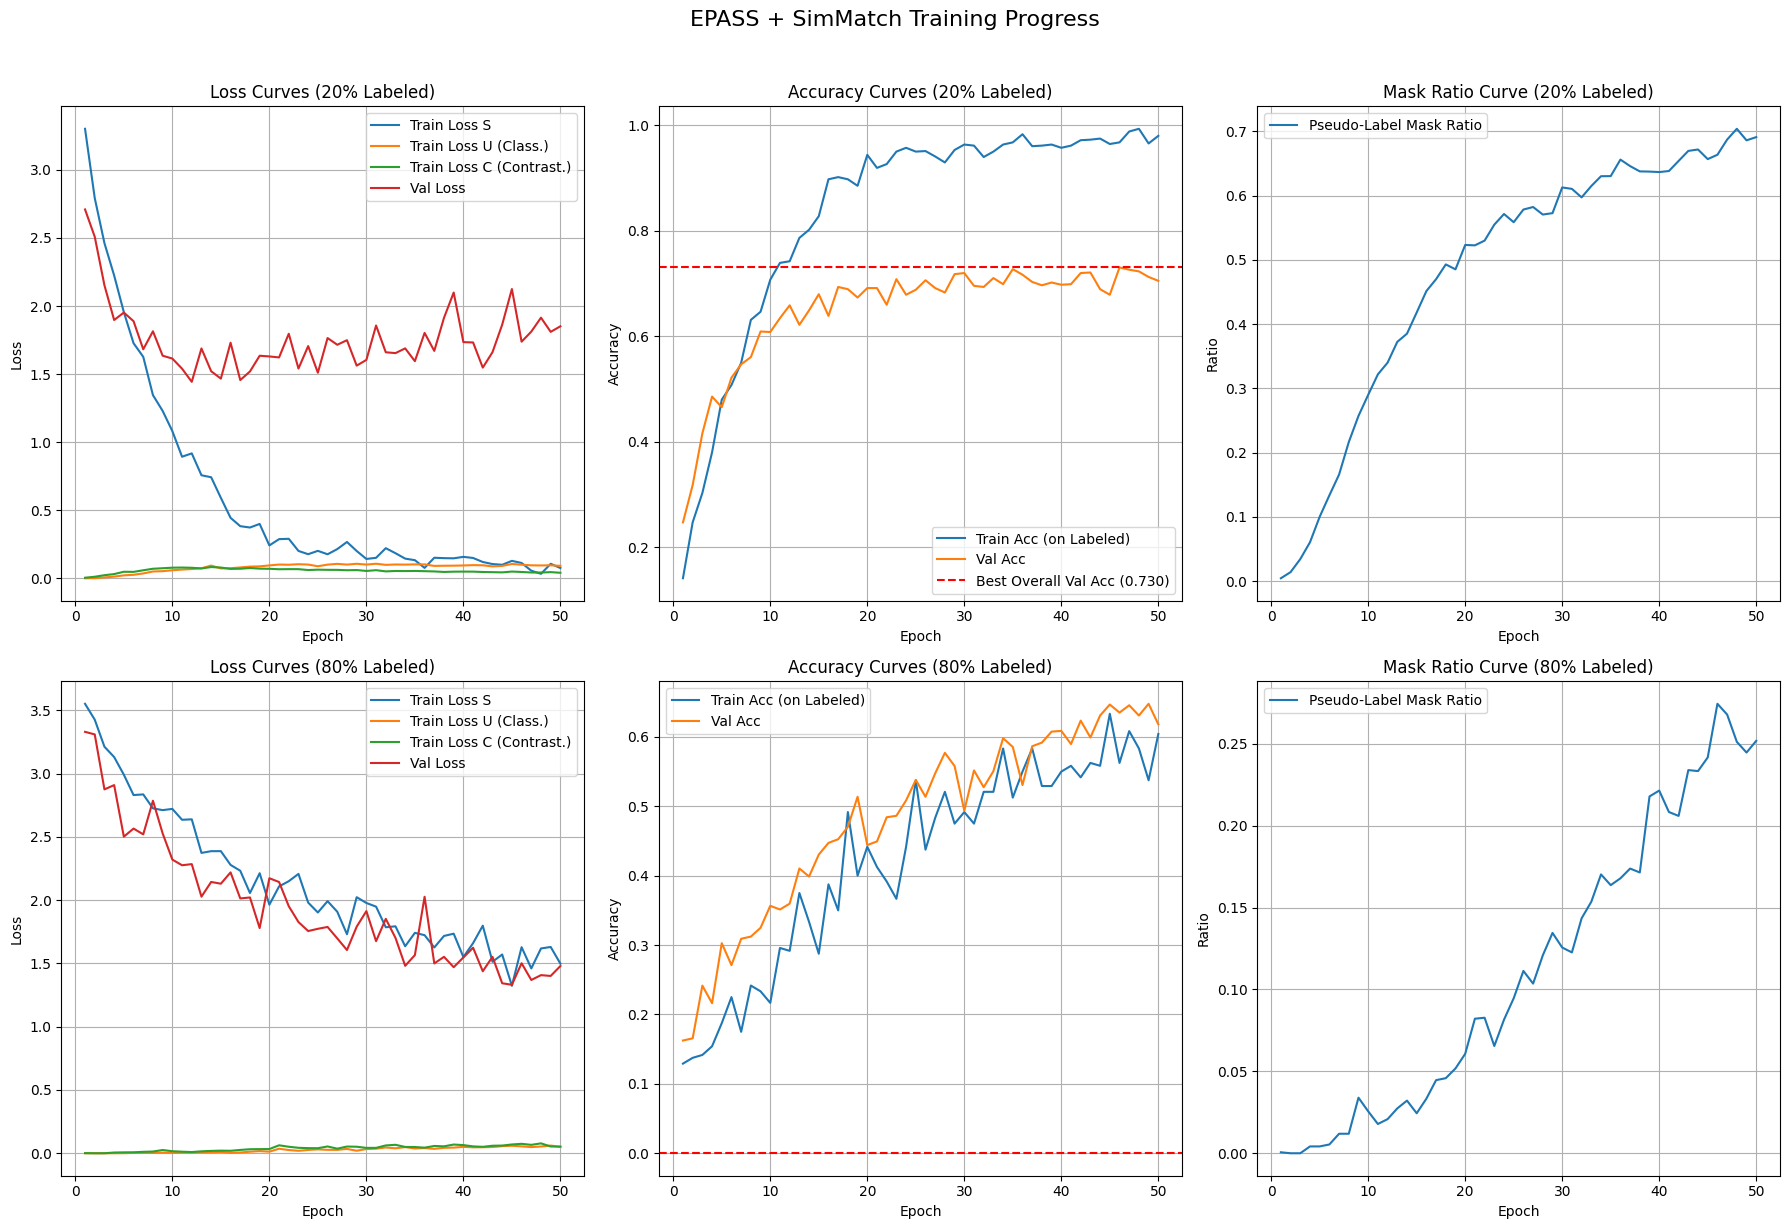


--- Analysis of Curves ---
Overfitting: Indicated if validation accuracy plateaus/decreases while training accuracy continues to rise, or if validation loss increases while training loss decreases.
Underfitting: Indicated if both training and validation accuracies are low and plateau early, or if losses remain high.
Target Accuracy (~80%): Observe if the best validation accuracy (0.7300) reached the target.


In [ ]:
# plot training curves
num_runs = len(config.labeled_percents)
fig, axes = plt.subplots(num_runs, 3, figsize=(18, 6 * num_runs), squeeze=False)

for i, percent in enumerate(config.labeled_percents):
    run_history = history[percent]
    epochs_range = range(1, len(run_history['train_loss_s']) + 1)

    # plot losses
    ax = axes[i, 0]
    ax.plot(epochs_range, run_history['train_loss_s'], label='Train Loss S')
    ax.plot(epochs_range, run_history['train_loss_u'], label='Train Loss U (Class.)')
    ax.plot(epochs_range, run_history['train_loss_c'], label='Train Loss C (Contrast.)')
    ax.plot(epochs_range, run_history['val_loss'], label='Val Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Loss Curves ({percent*100:.0f}% Labeled)')
    ax.legend()
    ax.grid(True)

    # plot accuracies
    ax = axes[i, 1]
    ax.plot(epochs_range, run_history['train_acc_l'], label='Train Acc (on Labeled)')
    ax.plot(epochs_range, run_history['val_acc'], label='Val Acc')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy Curves ({percent*100:.0f}% Labeled)')
    ax.legend()
    ax.grid(True)
    ax.axhline(y=best_val_acc_overall if best_labeled_percent == percent else 0, color='r', linestyle='--', label=f'Best Overall Val Acc ({best_val_acc_overall:.3f})' if best_labeled_percent == percent else None)
    if best_labeled_percent == percent: ax.legend() # show legend only if this run was best

    # plot mask ratio
    ax = axes[i, 2]
    ax.plot(epochs_range, run_history['mask_ratio'], label='Pseudo-Label Mask Ratio')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Ratio')
    ax.set_title(f'Mask Ratio Curve ({percent*100:.0f}% Labeled)')
    ax.legend()
    ax.grid(True)

plt.suptitle('EPASS + SimMatch Training Progress', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n--- Analysis of Curves ---")
print("Overfitting: Indicated if validation accuracy plateaus/decreases while training accuracy continues to rise, or if validation loss increases while training loss decreases.")
print("Underfitting: Indicated if both training and validation accuracies are low and plateau early, or if losses remain high.")
print(f"Target Accuracy (~80%): Observe if the best validation accuracy ({best_val_acc_overall:.4f}) reached the target.")